In [3]:
import sys
sys.path.append('../../../')
import torch
from matplotlib import pyplot as plt
from tifffile import imread, imwrite
from sklearn.cluster import KMeans
import numpy as np
from glob import glob
from tqdm import tqdm
import pandas as pd
import seaborn as sns

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
path="/group/jug/Sheida/pancreatic beta cells/download/high_c1/"
patch_size = 64
model = torch.load("/group/jug/Sheida/HVAE/446/model/Contrastive_MAE_best_vae.net")
model.mode_pred=True
model.eval()
model.to(device)

LadderVAE(
  (first_bottom_up): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BottomUpDeterministicResBlock(
      (res): ResidualBlock(
        (block): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Dropout2d(p=0.2, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Dropout2d(p=0.2, inplace=False)
        )
      )
    )
  )
  (top_down_layers): ModuleList(
    (0-1): 2 x TopDownLayer(
      (deterministic_block): Sequential(
        (0): TopDownDeterministicResBlock(
          (pre_conv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), 

In [6]:
centre_size = 4
n_channel = 32
hierarchy_level = 3

In [7]:
def get_normalized_tensor(img,model,device):
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [8]:
def load_data(dir):
    return imread(dir)

In [9]:
data_dir = "/localscratch/testing/img/"
golgi = get_normalized_tensor(load_data(data_dir+'class1/*.tif'), model, device)
mitochondria = get_normalized_tensor(load_data(data_dir+'class2/*.tif'), model, device)
granule = get_normalized_tensor(load_data(data_dir+'class3/*.tif'), model, device)
class_type = [golgi, mitochondria, granule]

In [10]:
def get_mean_centre(x, i):
    if i == 3:
        return x[i][0].cpu().numpy().reshape(n_channel,-1).mean(-1)
    elif i == 4:
        return x[i][0].cpu().numpy().reshape(n_channel,-1).mean(-1)
    else:
        lower_bound = 2**(5-1-i)-int(centre_size/2)
        upper_bound = 2**(5-1-i)+int(centre_size/2)
        return x[i][0].cpu().numpy()[:,lower_bound:upper_bound,lower_bound:upper_bound].reshape(n_channel,-1).mean(-1)

In [11]:
def get_mus(model, z):
    n_features = n_channel * hierarchy_level
    data = np.zeros((n_features,))
    model.mode_pred=True
    model.eval()
    with torch.no_grad():
        model.to(device)
        z = z.to(device=device, dtype=torch.float)
        z = z.reshape(1,1,patch_size,patch_size)
        with torch.no_grad():
                sample = model(z, z, z,model_layers=[0,1,2])
                mu = sample['mu']
                for i in range(hierarchy_level):
                    data[i*n_channel:(i+1)*n_channel] = get_mean_centre(mu, i)
                data = data.T.reshape(-1,n_features)
    return data

In [25]:
def get_sigmas(model, z):
    n_features = n_channel * hierarchy_level
    data = np.zeros((n_features,))
    model.mode_pred=True
    model.eval()
    with torch.no_grad():
        model.to(device)
        z = z.to(device=device, dtype=torch.float)
        z = z.reshape(1,1,patch_size,patch_size)
        with torch.no_grad():
                sample = model(z, z, z,model_layers=[0,1,2])
                sigma = sample['logvar']
                for i in range(hierarchy_level):
                    data[i*n_channel:(i+1)*n_channel] = get_mean_centre(sigma, i)
                data = data.T.reshape(-1,n_features)
    return data

In [41]:
def get_output(model, z):
    n_features = n_channel * hierarchy_level
    data = np.zeros((n_features,))
    model.mode_pred=True
    model.eval()
    with torch.no_grad():
        model.to(device)
        z = z.to(device=device, dtype=torch.float)
        z = z.reshape(1,1,patch_size,patch_size)
        with torch.no_grad():
                sample= model(z, z, z,model_layers=[0,1,2])
                out = sample['ll']
    return out

In [14]:
print(golgi.shape)

torch.Size([19, 64, 64])


In [47]:
import matplotlib.patches as patches

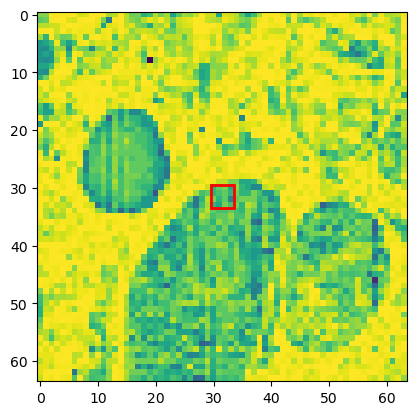

<Figure size 640x480 with 0 Axes>

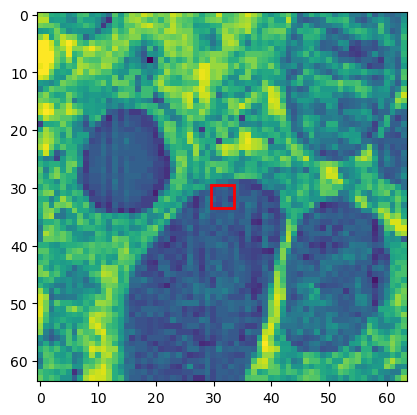

In [66]:
fig, ax = plt.subplots(1)

ax.imshow(get_output(model, mitochondria[10]).cpu().reshape(64, 64))
rect = patches.Rectangle((29.5, 29.5), 4, 4, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# ax.set_xlim(30 - 10, 30 + 4 + 10)
# ax.set_ylim(30 + 4 + 10, 30 - 10)
plt.show()
plt.clf()
fig, ax = plt.subplots(1)

ax.imshow(mitochondria[10].cpu())
rect = patches.Rectangle((29.5, 29.5), 4, 4, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# ax.set_xlim(30 - 10, 30 + 4 + 10)
# ax.set_ylim(30 + 4 + 10, 30 - 10)
plt.show()

In [12]:
mu = []
mus = np.array([])   
for class_t in range(len(class_type)):
    for i in tqdm(range(len(class_type[class_t]))):
        mu.extend(get_mus(model,class_type[class_t][i]))
    mus = np.append(mus, mu).reshape(-1, 96)
    mu = []
for i in range(len(mus)):
    mus[i] = np.asarray(mus[i])

100%|██████████| 363/363 [00:07<00:00, 46.03it/s]


In [32]:
mus.shape

(543, 96)

In [ ]:
sigma = []
sigmas = np.array([])
for class_t in range(len(class_type)):
    for i in tqdm(range(len(class_type[class_t]))):
        sigma.extend(get_sigmas(model,class_type[class_t][i]))
    sigmas = np.append(sigmas, sigma).reshape(-1, 96)
    sigma = []
for i in range(len(sigmas)):
    sigmas[i] = np.asarray(sigmas[i])

In [ ]:
data_A = pd.DataFrame(mus[:19,64])
data_B = pd.DataFrame(mus[19:180,64])
data_C = pd.DataFrame(mus[180:,64])

In [ ]:
data_A.columns = pd.MultiIndex.from_product([['A']])
data_B.columns = pd.MultiIndex.from_product([['B']])
data_C.columns = pd.MultiIndex.from_product([['C']])

In [ ]:
copy_to = data_A.loc[:].copy()
data_A = data_A._append([copy_to] * 58442, ignore_index=True)
copy_to = data_B.loc[:].copy()
data_B = data_B._append([copy_to] * 6896, ignore_index=True)
copy_to = data_C.loc[:].copy()
data_C = data_C._append([copy_to] * 3058, ignore_index=True)

In [ ]:
data_A.columns = pd.MultiIndex.from_product([['A'], range(2)])
data_B.columns = pd.MultiIndex.from_product([['B'], range(2)])
data_C.columns = pd.MultiIndex.from_product([['C'], range(2)])

In [ ]:
combined_data = pd.concat([data_A, data_B, data_C], axis=1)

In [ ]:
combined_data

In [ ]:
def calculate_average_correlation(data1, data2, var1, var2):
    combined = pd.concat([data1, data2], axis=1)
    common = combined.dropna()
    if not common.empty:
        full_corr = common.corr()
        indices_var1 = full_corr.loc[:, var1].columns.get_level_values(0) == var1
        indices_var2 = full_corr.loc[:, var2].columns.get_level_values(0) == var2
        avg_corr = full_corr.loc[var1, var2].values[indices_var1, :][:, indices_var2].mean()
        return avg_corr
    else:
        return np.nan # 19 161 363

In [ ]:
variables = ['A', 'B', 'C']
data_dict = {'A': data_A, 'B': data_B, 'C': data_C}

In [ ]:
simple_corr_matrix = pd.DataFrame(index=variables, columns=variables)

In [ ]:
simple_corr_matrix_1 = pd.DataFrame(index=variables, columns=variables)

In [ ]:
simple_corr_matrix_2 = pd.DataFrame(index=variables, columns=variables)

In [ ]:
for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            simple_corr_matrix.loc[var1, var2] = 1.0
        else:
            avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
            simple_corr_matrix.loc[var1, var2] = avg_corr
            simple_corr_matrix.loc[var2, var1] = avg_corr

print("Simplified 3x3 Correlation Matrix:\n", simple_corr_matrix)

In [ ]:
for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            simple_corr_matrix_1.loc[var1, var2] = 1.0
        else:
            avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
            simple_corr_matrix_1.loc[var1, var2] = avg_corr
            simple_corr_matrix_1.loc[var2, var1] = avg_corr

print("Simplified 3x3 Correlation Matrix:\n", simple_corr_matrix_1)

In [ ]:
for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            simple_corr_matrix_2.loc[var1, var2] = 1.0
        else:
            avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
            simple_corr_matrix_2.loc[var1, var2] = avg_corr
            simple_corr_matrix_2.loc[var2, var1] = avg_corr

print("Simplified 3x3 Correlation Matrix:\n", simple_corr_matrix_2)

In [ ]:
dfs = [pd.DataFrame() for _ in range(2)]
dfs[0] = simple_corr_matrix_1
dfs[1] = simple_corr_matrix_2
print(type(dfs))
averages = pd.concat([each.stack() for each in dfs],axis=1).apply(lambda x:x.mean(),axis=1).unstack()

In [ ]:
averages

In [ ]:
for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            simple_corr_matrix.loc[var1, var2] = 1.0
        else:
            avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
            simple_corr_matrix.loc[var1, var2] = avg_corr
            simple_corr_matrix.loc[var2, var1] = avg_corr

print("Simplified 3x3 Correlation Matrix:\n", simple_corr_matrix)

In [ ]:
dfs = [pd.DataFrame() for _ in range(96)]
variables = ['A', 'B', 'C']
for index_df in range(96):
    data_A = pd.DataFrame(mus[:19,index_df:index_df+1])
    data_B = pd.DataFrame(mus[19:180,index_df:index_df+1])
    data_C = pd.DataFrame(mus[180:,index_df:index_df+1])
    data_A.columns = pd.MultiIndex.from_product([['A']])
    data_B.columns = pd.MultiIndex.from_product([['B']])
    data_C.columns = pd.MultiIndex.from_product([['C']])
    data_dict = {'A': data_A, 'B': data_B, 'C': data_C}
    combined_data = pd.concat([data_A, data_B, data_C], axis=1)
    simple_corr_matrix = pd.DataFrame(index=variables, columns=variables)
    for var1 in variables:
        for var2 in variables:
            if var1 == var2:
                simple_corr_matrix.loc[var1, var2] = 1.0
            else:
                avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
                simple_corr_matrix.loc[var1, var2] = avg_corr
                simple_corr_matrix.loc[var2, var1] = avg_corr

    dfs[index_df] = simple_corr_matrix
    print(simple_corr_matrix)
averages = pd.concat([each.stack() for each in dfs],axis=1)\
             .apply(lambda x:x.mean(),axis=1)\
             .unstack()

In [ ]:
averages

In [ ]:
dfs = [pd.DataFrame() for _ in range(1000)]
for index_df in range(1000):
    i, j, k = np.random.randint(19), np.random.randint(19,180), np.random.randint(180,543)
    variables = ['A', 'B', 'C']
    data_A = pd.DataFrame(mus[i])
    data_B = pd.DataFrame(mus[j])
    data_C = pd.DataFrame(mus[k])
    data_A.columns = pd.MultiIndex.from_product([['A']])
    data_B.columns = pd.MultiIndex.from_product([['B']])
    data_C.columns = pd.MultiIndex.from_product([['C']])
    data_dict = {'A': data_A, 'B': data_B, 'C': data_C}
    combined_data = pd.concat([data_A, data_B, data_C], axis=0)
    simple_corr_matrix = pd.DataFrame(index=variables, columns=variables)
    for var1 in variables:
        for var2 in variables:
            if var1 == var2:
                simple_corr_matrix.loc[var1, var2] = 1.0
            else:
                avg_corr = calculate_average_correlation(data_dict[var1], data_dict[var2], var1, var2)
                simple_corr_matrix.loc[var1, var2] = avg_corr
                simple_corr_matrix.loc[var2, var1] = avg_corr
    dfs[index_df] = simple_corr_matrix

In [ ]:
print(mus[0][0], sigmas[0][0])

In [ ]:
from scipy.stats import norm

In [ ]:
mu, sigma = norm.fit(data_A)
print(mu, sigma)

In [ ]:
sns.histplot(data_A, kde=True)
plt.show()

In [ ]:
mu, sigma = norm.fit(data_B)
print(mu, sigma)
sns.histplot(data_B, kde=True)
plt.show()

In [ ]:
mu, sigma = norm.fit(data_C)
print(mu, sigma)
sns.histplot(data_C, kde=True)
plt.show()

In [ ]:
for dim in range(96):
    mu, sigma = norm.fit(mus[:,dim])
    print(mu, sigma)
    sns.histplot(mus[:,dim], kde=True)
    plt.show()


In [15]:
import scipy.stats as stats

In [16]:
def plot_qq(data, title='Q-Q Plot'):
    plt.figure(figsize=(10, 6))
    stats.probplot(data, dist='norm', plot=plt)
    plt.title(title)
    plt.show()

In [ ]:
for dim in range(96):
    plot_qq(mus[:,dim], title='Q-Q Plot for Mus')


In [13]:
from scipy.stats import shapiro
normal = 0
for dim in range(96):
    stat, p_value = shapiro(mus[:,dim])
    if p_value > 0.05:
        normal += 1
print("# of normal distributions ",normal)
print("# of not normal distributions ",96-normal)

# of normal distributions  0
# of not normal distributions  96


In [14]:
from scipy.stats import anderson
normal = 0
not_normal = 0
for dim in range(96):
    result = anderson(mus[:,dim], dist='norm')
    if result.statistic < result.critical_values[2]:
        normal += 1
    else:
        not_normal += 1
# Anderson-Darling test
print("# of normal distributions ",normal)
print("# of not normal distributions ",not_normal)

# of normal distributions  0
# of not normal distributions  96


In [22]:
from scipy.stats import norm, entropy
# List of distributions to check
distributions = ['norm', 'expon', 'lognorm']

# Store KLD values
kld_values = {}

# Compute KLD for each distribution
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    kld_values[dist_name] = []
    for i in range(96):
        params = dist.fit(mus[:,i])
        hist, bin_edges = np.histogram(mus[:,i], bins=100, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        fitted_pdf = dist.pdf(bin_centers, *params)
        kld = entropy(hist, fitted_pdf)
        kld_values[dist_name].append(kld)

        # # Plot the fitted PDF
        # plt.plot(bin_centers, fitted_pdf, linewidth=2, label=f'Fitted {dist_name.title()}')


        # plt.title('Sample PDF vs Fitted Distributions')
        # plt.legend()
        # plt.show()
        # plt.clf()

# Print KLD values
for dist_name, kld_value in kld_values.items():
    print(f'Kullback-Leibler Divergence (KLD) to {dist_name} distribution: {kld_value}')


/localscratch/envs/maester_ls/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


Kullback-Leibler Divergence (KLD) to norm distribution: [0.09941216637547869, 0.12159206924329051, 0.0884707768425513, 0.11004901390900447, 0.10718388057957581, 0.09214281649759751, 0.08981871673032471, 0.14139806277089512, 0.10166474491579498, 0.0960665979544558, 0.09623319316067838, 0.12464272125103051, 0.1183764934128804, 0.08833073021367153, 0.0934875699792224, 0.09795252757819517, 0.11716349880084977, 0.08144912760757217, 0.1172066013476138, 0.08925189967461243, 0.1016657650110924, 0.08718163929397751, 0.09585707906677203, 0.10001317945968363, 0.11962782223572364, 0.11239266620779506, 0.09360233646237644, 0.12373960207361716, 0.11946411351393722, 0.11029275028661402, 0.11172907989376712, 0.09058527047594511, 0.10731098359897062, 0.09265562312148352, 0.11947904844397128, 0.1123625536922015, 0.11996674041294596, 0.0912134735135164, 0.12901774761023646, 0.0927262137861846, 0.0954706331594284, 0.10530447703967782, 0.09520347231117936, 0.09797727249306025, 0.10669511044962807, 0.109827

In [23]:
norm_dist, expo_dist, lognorm_dist = 0, 0, 0
for dim in range(96):
    min_kld = min(kld_values['norm'][dim], kld_values['expon'][dim], kld_values['lognorm'][dim])
    if min_kld == kld_values['norm'][dim]:
        norm_dist += 1
    elif min_kld == kld_values['expon'][dim]:
        expo_dist += 1
    else:
        lognorm_dist += 1
print("# of normal distributions ",norm_dist, " # of exponential distributions ", expo_dist, " # of lognormal distributions ", lognorm_dist)

# of normal distributions  57  # of exponential distributions  0  # of lognormal distributions  39


In [ ]:
data = np.random.normal(mus[0][0], sigmas[0][0], 1000)
sns.histplot(data, kde=True)
plt.show()

In [ ]:
dfs

In [ ]:
averages = pd.concat([each.stack() for each in dfs],axis=1)\
             .apply(lambda x:x.mean(),axis=1)\
             .unstack()
averages

In [ ]:
sample_size = 100000
sampled_data = combined_data.sample(n=sample_size, random_state=42)


In [ ]:

correlation_matrix = combined_data.corr()

In [ ]:
correlation_matrix

In [ ]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix Heatmap')
# plt.xlabel('Variables')
# plt.ylabel('Variables')
# plt.show()
plt.imshow(averages, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
def clustering(mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(160, -1).T
    K_CENTRE = 4
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

In [ ]:
def get_normalized_tensor(img,model,device):
    '''
    Normalizes tensor with mean and std.
    Parameters
    ----------
    img: array
        Image.
    model: Hierarchical DivNoising model
    device: GPU device.
    '''
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [ ]:
# for 4x4
def make_tiled(img):
    out = np.zeros([img.shape[0]+61, img.shape[1]+60])
    # make mirror margin of 2d image
    for i in range(30):
        out[i,30:30+img.shape[1]] = img[30-i-1,:]
        out[30:30+img.shape[0],30:30+img.shape[1]] = img
        out[30+img.shape[0]+i,30:30+img.shape[1]] = img[img.shape[0]-i-1,:]
    out[img.shape[0]+60,30:30+img.shape[1]] = img[img.shape[0]-31,:]
    for i in range(30):
        out[:,i] = out[:,60-i-1]
        out[:, 30+img.shape[1]+i] = out[:, 30+img.shape[1]-i-1]
    return out
    

In [ ]:
# for 2x2
def make_tiled_x(img):
    out = np.zeros([img.shape[0]+63, img.shape[1]+62])
    # make mirror margin of 2d image
    for i in range(31):
        out[i,31:31+img.shape[1]] = img[31-i-1,:]
        out[31:31+img.shape[0],31:31+img.shape[1]] = img
        out[31+img.shape[0]+i,31:31+img.shape[1]] = img[img.shape[0]-i-1,:]
    out[img.shape[0]+62,31:31+img.shape[1]] = img[img.shape[0]-32,:]
    for i in range(31):
        out[:,i] = out[:,62-i-1]
        out[:, 31+img.shape[1]+i] = out[:, 31+img.shape[1]-i-1]
    return out

In [ ]:
# img = imread(path+"data/test/high_c1_source_31.tif")
img = imread("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif")
tiled = make_tiled(img)
img_height,img_width = 700,760
img = get_normalized_tensor(tiled,model,device)
output = np.zeros((32, 700, 760))
for i in tqdm(range(0, img_height, 4)):
    for j in range(0, img_width, 4):
# for i in tqdm(range(0, img_height, 2)):
#     for j in range(0, img_width, 2):
        img_t = img[i:i+64,j:j+64]
        # if img_t.shape != (64,64):
        #     print(img_t.shape)
        image_sample = img_t.view(1,1,64,64)
        image_sample = image_sample.to(device=device, dtype=torch.float)
        with torch.no_grad():
            sample = model(image_sample, y=image_sample)
            mus = sample['mu']
            output[:32,i:i+4,j:j+4] = sample['mu'][0][0].cpu().numpy()[:,14:18,14:18]
            # output[32:64,i:i+4,j:j+4] = sample['mu'][1][0].cpu().numpy()[:,6:10,6:10]
            # output[64:96,i:i+4,j:j+4] = sample['mu'][2][0].cpu().numpy()[:,2:6,2:6]
            # output[96:128,i:i+4,j:j+4] = sample['mu'][3][0].cpu().numpy()
            # output[128:160,i:i+4,j:j+4] = sample['mu'][4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)
            # output[:32,i:i+2,j:j+2] = sample['mu'][0][0].cpu().numpy()[:,15:17,15:17]
            # output[32:64,i:i+2,j:j+2] = sample['mu'][1][0].cpu().numpy()[:,7:9,7:9]
            # output[64:96,i:i+2,j:j+2] = sample['mu'][2][0].cpu().numpy()[:,3:5,3:5]
            # output[96:128,i:i+2,j:j+2] = sample['mu'][3][0].cpu().numpy()[:,1:3,1:3]
            # output[128:160,i:i+2,j:j+2] = sample['mu'][4][0].cpu().numpy()


In [ ]:
np.save("/group/jug/Sheida/HDN_models/27022024/Contrastive_False/imgs/output_187.npy", output)

In [ ]:
output = np.load("/group/jug/Sheida/HDN_models/27022024/Contrastive_False/imgs/output_187.npy")

In [ ]:
clusters = clustering(output)

In [ ]:
# imwrite("/group/jug/Sheida/HDN_models/27022024/Contrastive_False/imgs/187_8_cluster.tif", clusters.reshape(700, 760))
plt.imshow(clusters.reshape(700, 760))
plt.show()

In [ ]:
# imwrite("/group/jug/Sheida/HDN_models/22022024/Trained_model_3/imgs/187_8_cluster_downscale_2.tif", clusters.reshape(700, 760)[::2,::2])
plt.imshow(clusters.reshape(700, 760)[::2,::2])
plt.show()

In [ ]:
# imwrite("/group/jug/Sheida/HDN_models/22022024/Trained_model_3/imgs/187_8_cluster_downscale_4.tif", clusters.reshape(700, 760)[::4,::4])
plt.imshow(clusters.reshape(700, 760)[::4,::4])
plt.show()

In [ ]:
def clustering_down_scale(index, mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(32, -1).T
    K_CENTRE = 8
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

In [ ]:
files = glob("/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/test/mito_golgi_gra/high_c1_source_187.tif")
img_height,img_width = 699, 760
for i in files:
    img = imread(i)
    img_t = get_normalized_tensor(img,model,device)
    image_sample = img_t.view(1,1,img_height,img_width)
    image_sample = image_sample.to(device=device, dtype=torch.float)
    with torch.no_grad():
        sample = model(image_sample, image_sample)
        mus = sample['mu']
        output = np.zeros((160, 768, 704))

        print(output.shape)

        for idx in range(len(sample['mu'])):
            mu = sample['mu'][idx][0].cpu().numpy()
            print(mu.shape)
            output = clustering_down_scale(idx, mu)
            print(i)
            imwrite("/group/jug/Sheida/HDN_models/27022024/Contrastive_False/imgs/187_"+str(idx)+".tif", output.reshape(22*(2**(4-idx)), 24*(2**(4-idx))))
            plt.imshow(output.reshape(22*(2**(4-idx)), 24*(2**(4-idx))))
            plt.show()

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import torch
import numpy as np
from scipy.stats import norm 
from torch.distributions import kl_divergence
from torch.distributions.normal import Normal

input = Normal(torch.tensor([0 for i in range(5)]), torch.tensor([1 for i in range(5)]))
target = Normal(torch.tensor([0.5 for i in range(5)]), torch.tensor([1 for i in range(5)]))
output = kl_divergence(input, target)
print("input: ",input,"\ntarget: ",target,"\noutput: ",output)
print(torch.sum(output))
plt.plot(np.arange(-20,20,8), norm.pdf(np.arange(-20,20,8), [0 for i in range(5)], [0.5 for i in range(5)]))
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

# Assuming latent_z and labels are your latent space representations and true labels
silhouette_avg = silhouette_score(latent_z, labels)
davies_bouldin = davies_bouldin_score(latent_z, labels)
